<h1><center> Práctica de Teoría de la Información</center></h1>


<h3><center>María Barroso Honrubia y Gloria del Valle Cano</center></h3>

En esta práctica se aplican técnicas de Teoría de la Información con el objetivo de estudiar la transmisión de información mutua entre dos neuronas principales, LP (Lateral Pyloric Neuron) y VD (Ventricular Dilator Neuron), las cuales pertenecen al sistema nervioso de un cangrejo. Gracias a la aportación de los datos facilitados de la sinapsis, se pueden distinguir las diferentes etapas en cada una de las neuronas:

* Control: etapa donde se mide el potencial de las neuronas en su estado inicial.
* Inyección de GABA: etapa donde se mide el potencial tras haber inyectado ácido $\gamma$-aminobutírico.
* Recuperación: etapa donde se mide el potencial de las neuronas tras dejar el sistema en reposo.

De esta manera estudiaremos la transmisión de información mutua tras un análisis completo de estas series, asumiendo que los *spikes* (aumentos rápidos del potencial) son los eventos que inicialmente tienen la información.

## 0. Importación de librerías

In [2]:
import math
import json
import zipfile
import pandas as pd
import numpy as np

from io import BytesIO
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from skimage.util import view_as_windows
from collections import defaultdict

file_path = '../../DatosSinapsisArtificial'
#file_path = '/home/maria/Escritorio/DatosSinapsisArtificial'
neurons = ['LP','VD']

## 1. Carga de datos
Utilizamos una función, $\texttt{zip\_to\_dataframe}$, para cargar los datos de la sinapsis, de manera que convertimos a un $\texttt{Dataframe}$ de $\texttt{pandas}$ para así manipularlos facilmente.

In [3]:
def zip_to_dataframe(file_path, file_name, neurons):
    """
    Load data from zip to pandas dataframe.
    Args:
        file_path (str): path to file
        file_name (str): file name (TrozoC, TrozoG or TrozoR)
        neurons: neurons name
    """
    file_path_zip = f'{file_path}/{file_name}.zip'
    file_name_txt = f'{file_name}.txt'
    with zipfile.ZipFile(file_path_zip) as thezip:
        with thezip.open(file_name_txt, mode='r') as thefile:
            data = thefile.read()
            return pd.read_csv(BytesIO(data), sep='\t', index_col=False, names=neurons, skiprows=range(3), decimal=',')
        
def load_data(file_path, file_name, neurons):
    """
    Load data and show main information.
    Args:
        file_path (str): path to file
        file_name (str): file name (TrozoC, TrozoG or TrozoR)
        neurons: neurons name
    """
    print("________________ {0} ________________".format(file_name))
    trozo = zip_to_dataframe(file_path, file_name, neurons)
    print(trozo.head())
    print('Number of channels: {0}'.format(len(trozo.columns)))
    print('Number of samples per channel: {0}\n'.format(len(trozo)))
    return trozo

In [4]:
trozoC = load_data(file_path, 'TrozoC', neurons)
trozoG = load_data(file_path, 'TrozoG', neurons)
trozoR = load_data(file_path, 'TrozoR', neurons)

________________ TrozoC ________________
         LP        VD
0  0.004883  0.015259
1  0.001526  0.024109
2 -0.010681  0.031128
3 -0.022278  0.041809
4 -0.028076  0.045471
Number of channels: 2
Number of samples per channel: 19847700

________________ TrozoG ________________


/home/maria/main/main/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


         LP        VD
0 -0.006104  0.064697
1 -0.004272  0.075989
2 -0.003357  0.087280
3 -0.005188  0.092468
4 -0.007324  0.093384
Number of channels: 2
Number of samples per channel: 16384000

________________ TrozoR ________________
         LP        VD
0 -0.008240  0.084534
1 -0.009460  0.070190
2 -0.014038  0.049133
3 -0.021973  0.035400
4 -0.035095  0.022888
Number of channels: 2
Number of samples per channel: 16384000



## 2. Análisis de los datos

### 2.1. Análisis de cada uno de los trozos

In [5]:
def chunk_analysis(trozo, name, n, dt):
    """
        Shows relevant information from file name selected.
        Args:
            trozo (Dataframe): dataframe to analyze (TrozoC, TrozoG or TrozoR)
            n (int): numer of data points
            dt (float): interval
    """
    t = np.arange(0, n*dt, dt)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, constrained_layout=True)
    fig.set_size_inches(16, 8)
    fig.suptitle('Control ({0})'.format(name), fontsize=20)

    ax1.grid(True)
    ax1.plot(t, trozo.LP.iloc[:n], lw=0.4)
    ax1.set_title('LP', fontsize=16)
    
    ax2.grid(True)
    ax2.plot(t, trozo.VD.iloc[:n],'tab:orange', lw=0.4)
    ax2.set_title('VD', fontsize=16)

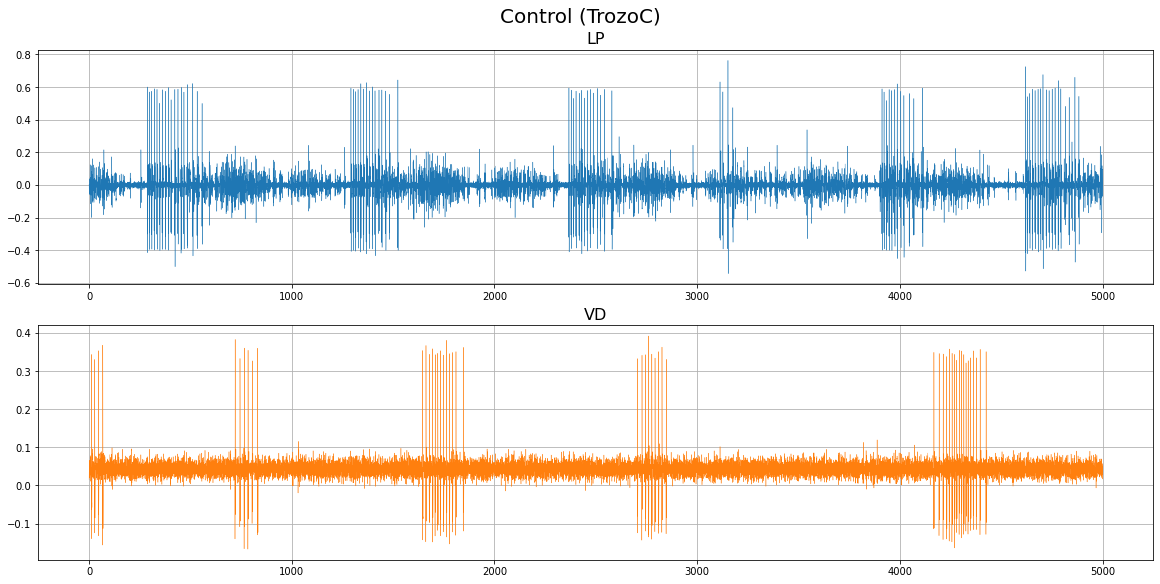

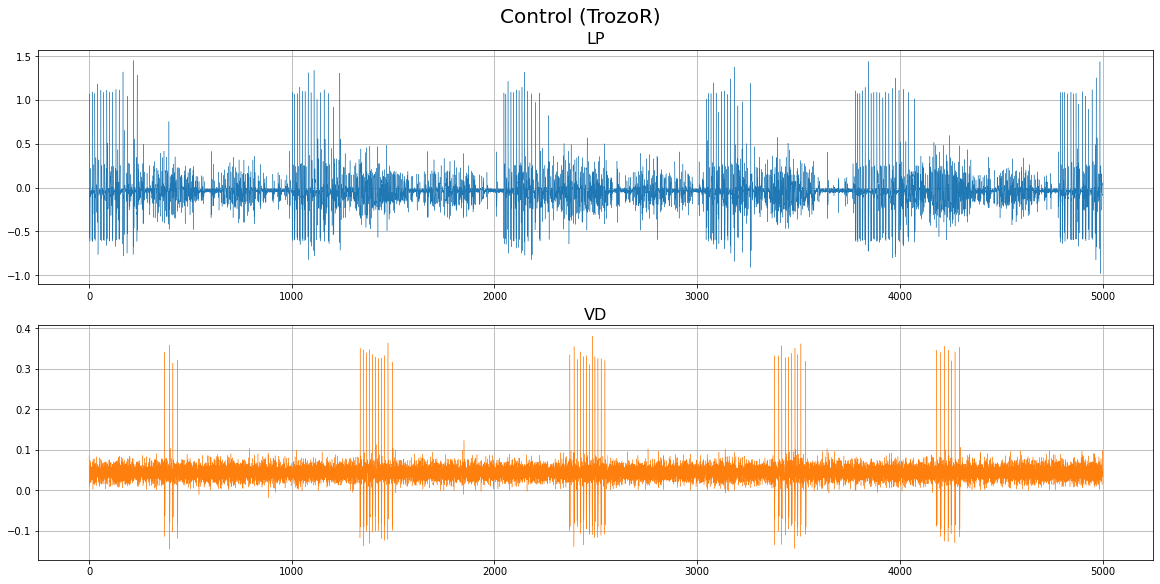

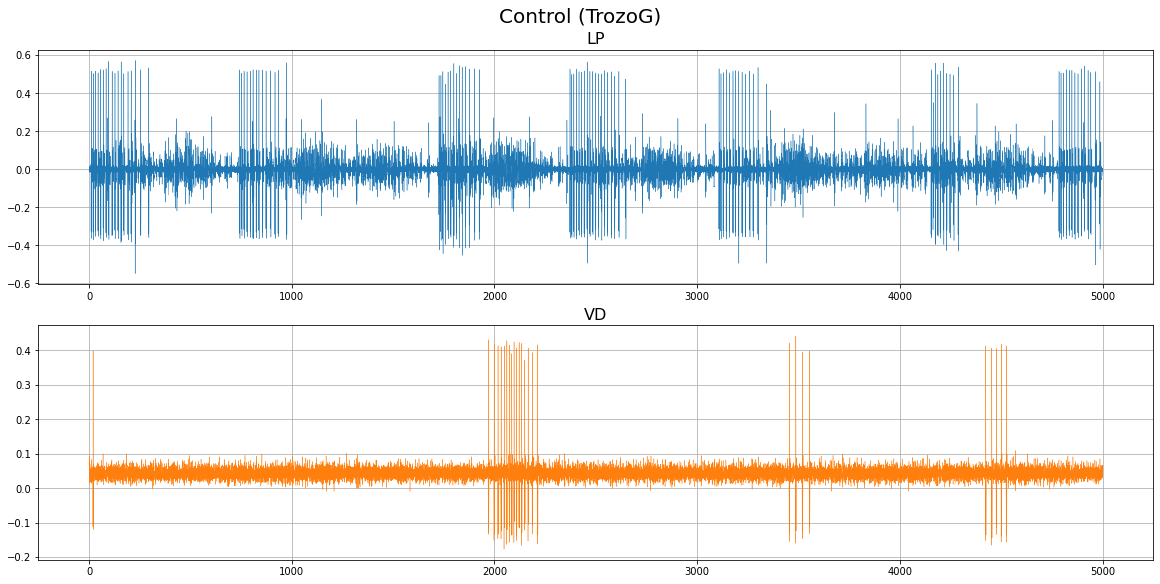

In [6]:
n = 50000
dt = 0.1
chunk_analysis(trozoC, 'TrozoC', n, dt)
chunk_analysis(trozoR, 'TrozoR', n, dt)
chunk_analysis(trozoG, 'TrozoG', n, dt)

### 2.2. Detección de Spikes
#### 2.2.1. Utilizando el método estadístico
Evaluamos la dispersión y la distribución del dataset con el objetivo de encontrar los spikes y el umbral para cada neurona.

________________ TrozoC ________________
Dataset distribution (TrozoC): 
                 LP            VD
count  1.984770e+07  1.984770e+07
mean  -2.253853e-08  4.385849e-02
std    8.214042e-02  3.287948e-02
min   -7.101440e-01 -2.170715e+00
25%   -2.288800e-02  3.295900e-02
50%    3.050000e-04  4.364000e-02
75%    2.410900e-02  5.401600e-02
max    9.344480e-01  1.351624e+00


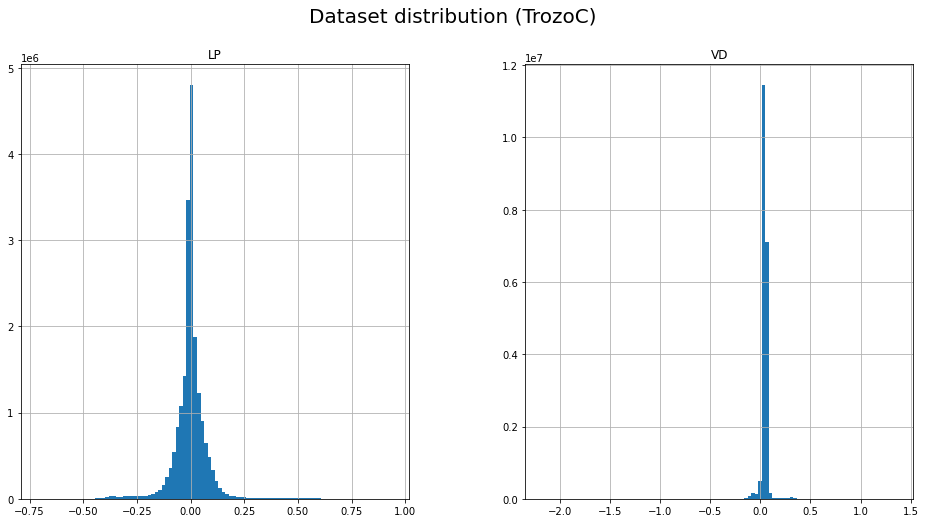

Threshold for each neuron (TrozoC):
LP    0.37
VD    0.20
dtype: float64
________________ TrozoG ________________
Dataset distribution (TrozoG): 
                 LP            VD
count  1.638400e+07  1.638400e+07
mean   1.782227e-11  4.330900e-02
std    8.109792e-02  3.337760e-02
min   -6.420900e-01 -3.088380e-01
25%   -2.624500e-02  3.326400e-02
50%    0.000000e+00  4.303000e-02
75%    2.441400e-02  5.310100e-02
max    9.265140e-01  5.520630e-01


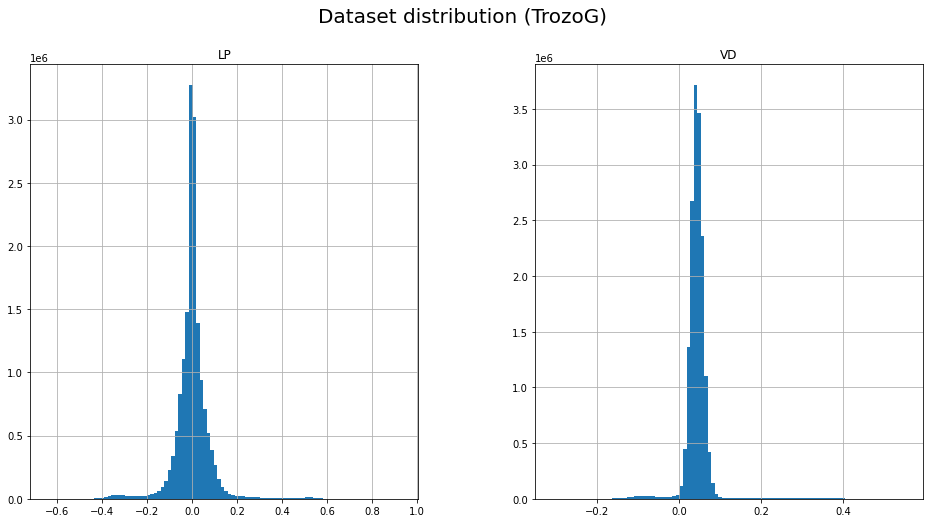

Threshold for each neuron (TrozoG):
LP    0.37
VD    0.20
dtype: float64
________________ TrozoR ________________
Dataset distribution (TrozoR): 
                 LP            VD
count  1.638400e+07  1.638400e+07
mean  -3.341000e-02  4.389221e-02
std    1.948664e-01  3.313382e-02
min   -1.328430e+00 -2.170715e+00
25%   -1.058960e-01  3.295900e-02
50%   -3.662100e-02  4.364000e-02
75%    1.770000e-02  5.432100e-02
max    1.992188e+00  1.351624e+00


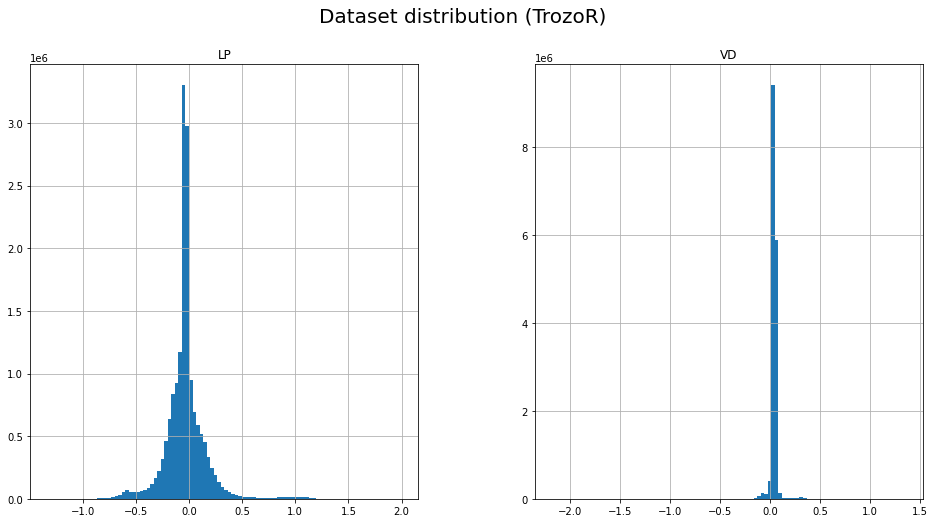

Threshold for each neuron (TrozoR):
LP    0.85
VD    0.20
dtype: float64


In [7]:
def get_threshold(df, precision=2):
    """
    
    """
    r = df.mean() + 4.5*df.std()
    return np.round(r + 0.5 * 10**(-precision), precision)

def get_spikes(trozo, name):
    """
    
    """
    print("________________ {0} ________________".format(name))
    print("Dataset distribution ({0}): ".format(name))
    print("{0}".format(trozo.describe()))
    histogram = trozo.hist(figsize = (16, 8), bins = 100)
    plt.suptitle('Dataset distribution ({0})'.format(name), fontsize=20)
    plt.show()
    
    threshold = get_threshold(trozo)
    print('Threshold for each neuron ({0}):'.format(name))
    print('{0}'.format(threshold))
    return threshold

thresholdC = get_spikes(trozoC, 'TrozoC')
thresholdG = get_spikes(trozoG, 'TrozoG')
thresholdR = get_spikes(trozoR, 'TrozoR')

#### 2.2.2. Utilizando la propia función de Scipy

________________ TrozoC ________________
Total spikes (LP): 31231
Total spikes (VD): 22335
________________ TrozoG ________________
Total spikes (LP): 26633
Total spikes (VD): 15662
________________ TrozoR ________________
Total spikes (LP): 24961
Total spikes (VD): 18674


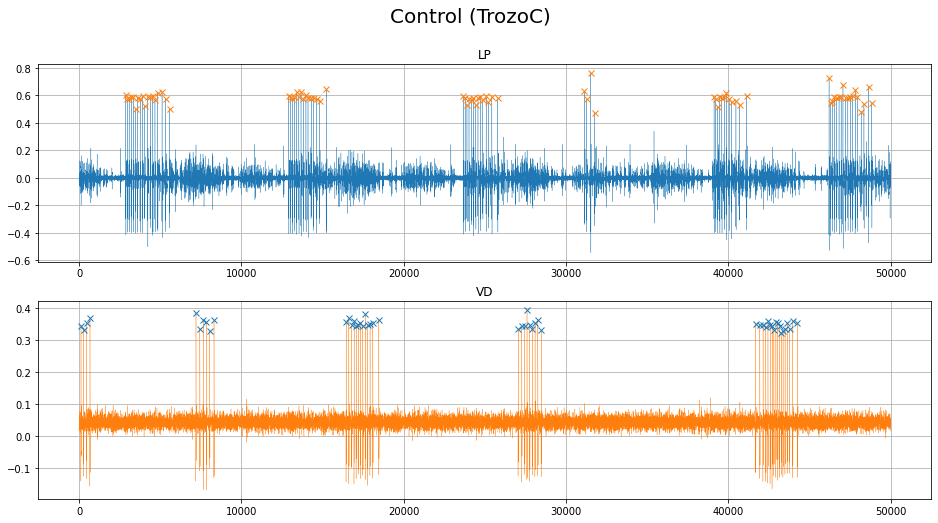

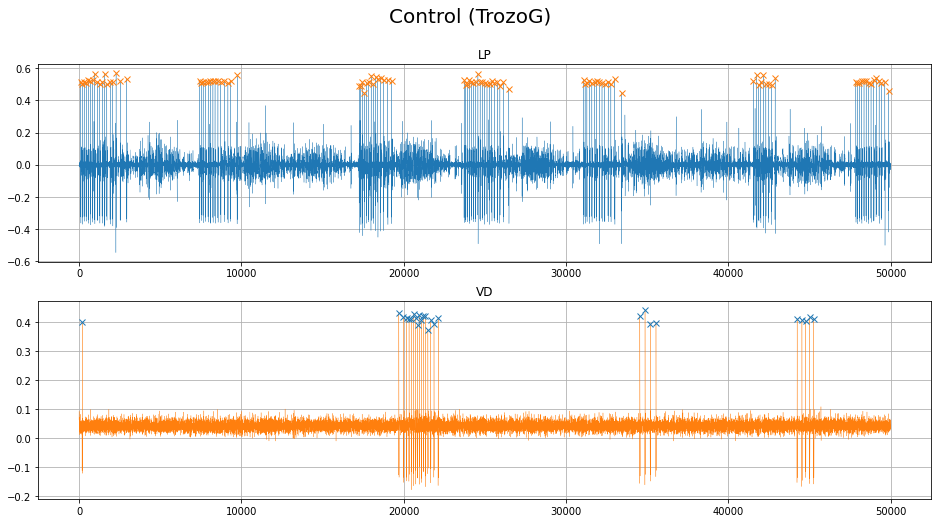

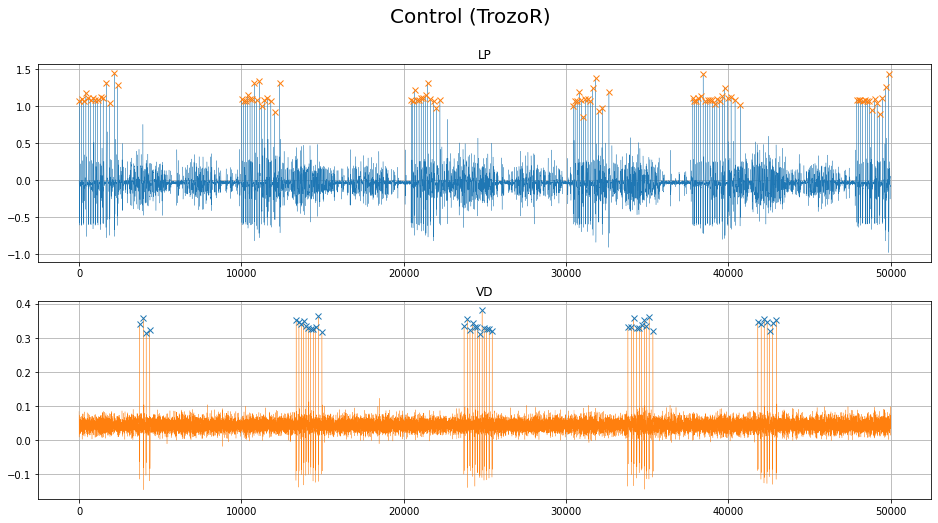

In [8]:
def find_events(trozo, n, threshold, name):
    """
    
    """

    print("________________ {0} ________________".format(name))
    clp_spikes, _ = find_peaks(trozo.LP[:n], threshold[0])
    cvd_spikes, _ = find_peaks(trozo.VD[:n], threshold[1])
    
    t_lp,_ = find_peaks(trozo.LP, threshold[0])
    t_vd,_ = find_peaks(trozo.VD, threshold[1])
    print("Total spikes (LP): {0}".format(len(t_lp)))
    print("Total spikes (VD): {0}".format(len(t_vd)))
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    fig.suptitle('Control ({0})'.format(name), fontsize=20)

    ax1.plot(trozo.LP[:n], lw=0.3)
    ax1.plot(clp_spikes, trozo.LP[:n][clp_spikes], "x")
    ax1.set_title("LP")
    ax1.grid(True)

    ax2.plot(trozo.VD[:n],'tab:orange', lw=0.3)
    ax2.plot(cvd_spikes, trozo.VD[:n][cvd_spikes], "x")
    ax2.set_title("VD")
    ax2.grid(True)
    
    return t_lp, t_vd

clp_spikes_C, cvd_spikes_C = find_events(trozoC, 50000, thresholdC, 'TrozoC')
clp_spikes_G, cvd_spikes_G = find_events(trozoG, 50000, thresholdG, 'TrozoG')
clp_spikes_R, cvd_spikes_R = find_events(trozoR, 50000, thresholdR, 'TrozoR')

Buscamos la manera de encontrar la distancia entre spikes

________________ TrozoC ________________
________ LP ________
Min: 3
Max: 22323
Mean: 635.3495036823567
Medium: 154.0
Q1: 24.80725
________ VD ________
Min: 4
Max: 29910
Mean: 888.3783469150175
Medium: 160.0
Q1: 17.1665
________________ TrozoG ________________
________ LP ________
Min: 4
Max: 14121
Mean: 614.9039876839892
Medium: 155.0
Q1: 24.65775
________ VD ________
Min: 2
Max: 21409
Mean: 1045.8287465679075
Medium: 191.0
Q1: 62.915
________________ TrozoR ________________
________ LP ________
Min: 40
Max: 23023
Mean: 656.3359375
Medium: 155.0
Q1: 41.23975
________ VD ________
Min: 4
Max: 29910
Mean: 877.213677502276
Medium: 159.0
Q1: 14.008000000000001


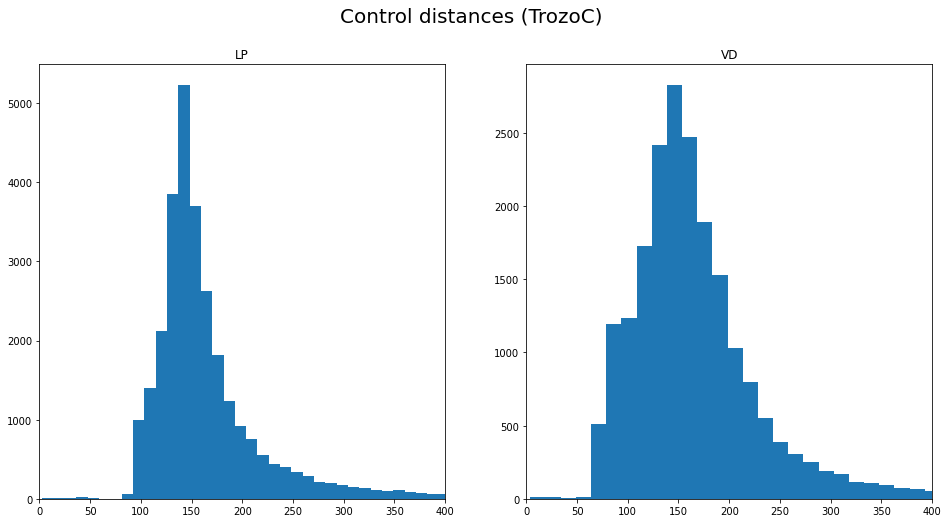

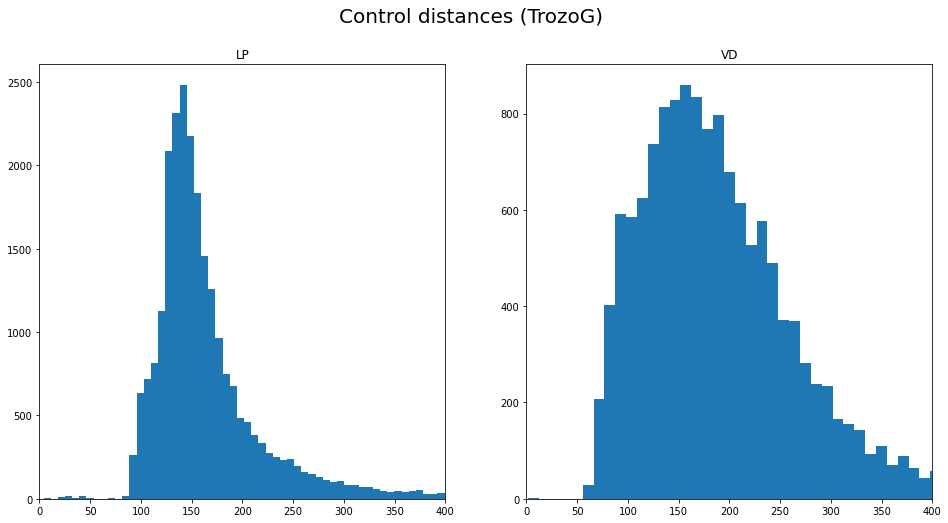

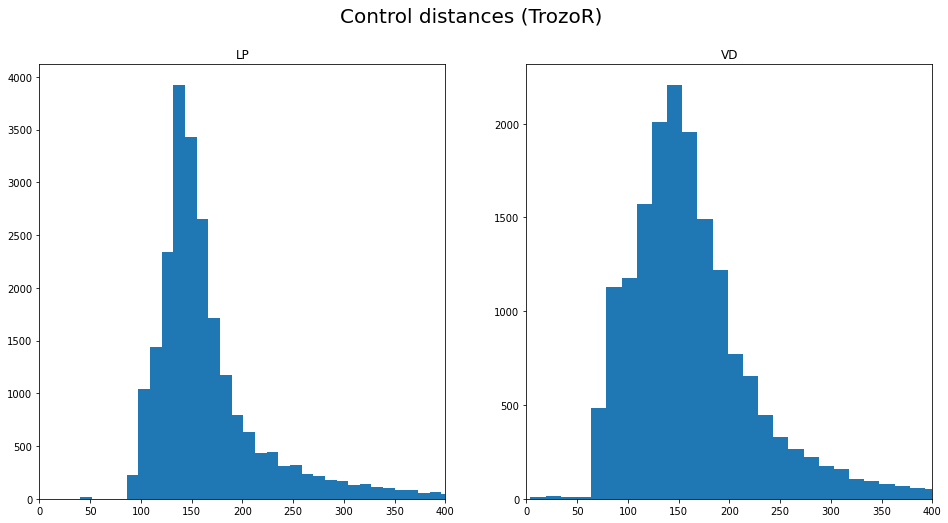

In [9]:
def distances_b_spikes(name, clp_spikes, cvd_spikes, q):

    clp_distances = np.diff(clp_spikes)
    cvd_distances = np.diff(cvd_spikes)
    
    print("________________ {0} ________________".format(name))
    print("________ LP ________")
    print('Min: {0}'.format(np.amin(clp_distances)))
    print('Max: {0}'.format(np.amax(clp_distances)))
    print('Mean: {0}'.format(np.mean(clp_distances)))
    print('Medium: {0}'.format(np.median(clp_distances)))
    print('Q1: {0}'.format(np.quantile(clp_distances, q)))
    print("________ VD ________")
    print('Min: {0}'.format(np.amin(cvd_distances)))
    print('Max: {0}'.format(np.amax(cvd_distances)))
    print('Mean: {0}'.format(np.mean(cvd_distances)))
    print('Medium: {0}'.format(np.median(cvd_distances)))
    print('Q1: {0}'.format(np.quantile(cvd_distances, q)))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)
    fig.suptitle('Control distances ({0})'.format(name), fontsize=20)

    ax1.hist(clp_distances, bins=2000)
    ax1.set_xlim((0, 400))
    ax1.set_title("LP")

    ax2.hist(cvd_distances, bins=2000)
    ax2.set_title("VD")
    ax2.set_xlim((0, 400))

distances_b_spikes('TrozoC', clp_spikes_C, cvd_spikes_C, 0.00025)
distances_b_spikes('TrozoG', clp_spikes_G, cvd_spikes_G, 0.00025)
distances_b_spikes('TrozoR', clp_spikes_R, cvd_spikes_R, 0.00025)

### 2.3. Discretización


Yo creo que quitaría esta visualización de datos.

,LP,VD,LP_events,VD_events
0,-0.008240,0.084534,0,0
1,-0.009460,0.070190,0,0
2,-0.014038,0.049133,0,0
3,-0.021973,0.035400,0,0
4,-0.035095,0.022888,0,0
...,...,...,...,...
16383995,0.310669,0.053101,0,0
16383996,0.286560,0.045166,0,0
16383997,0.251160,0.036926,0,0
16383998,0.207214,0.023499,0,0


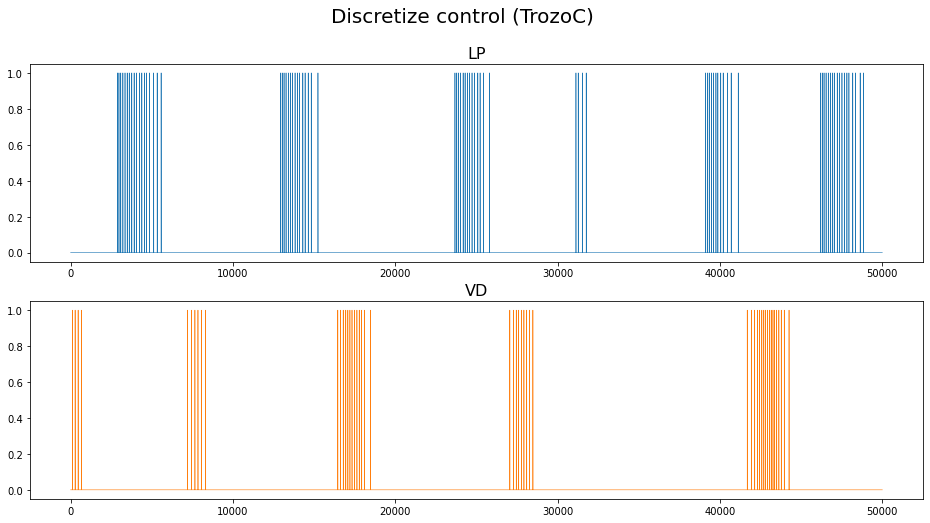

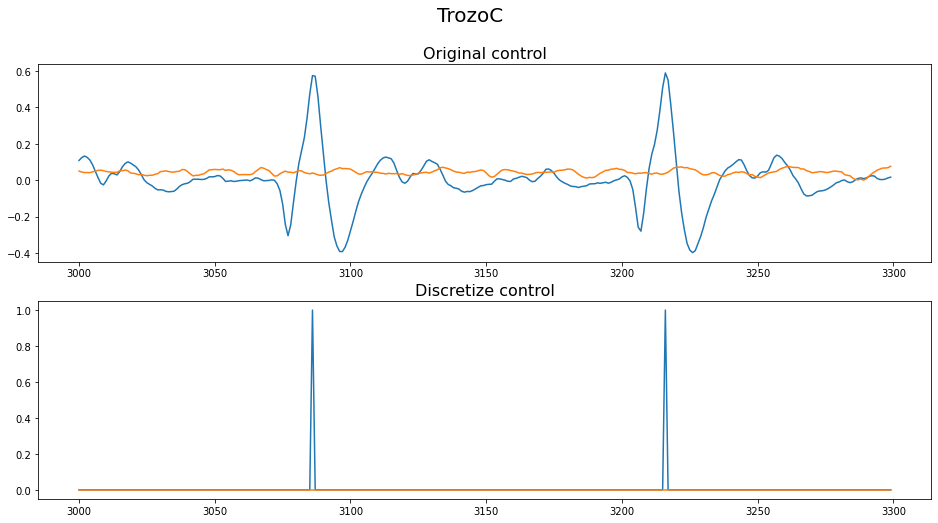

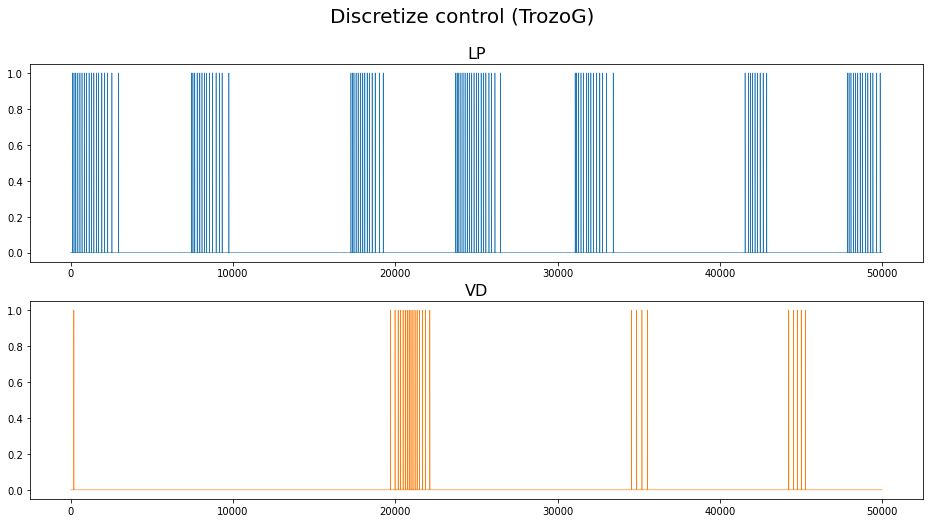

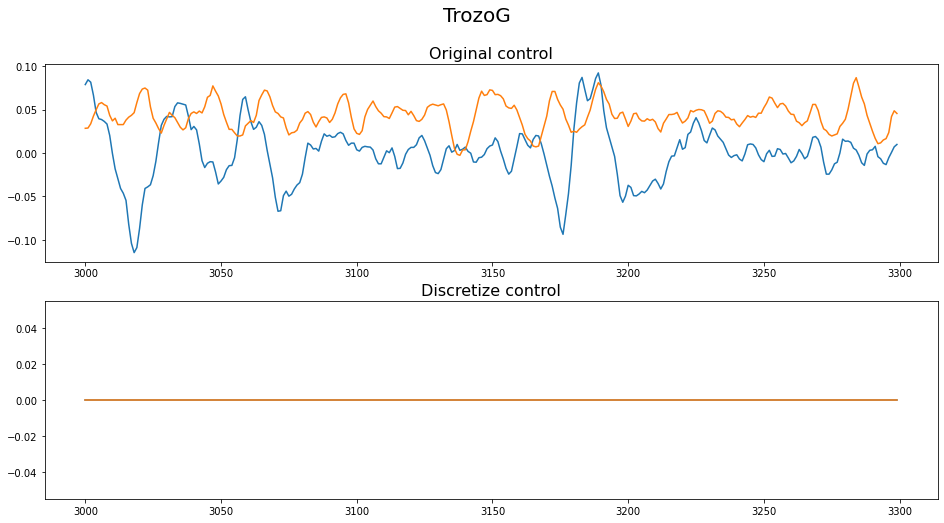

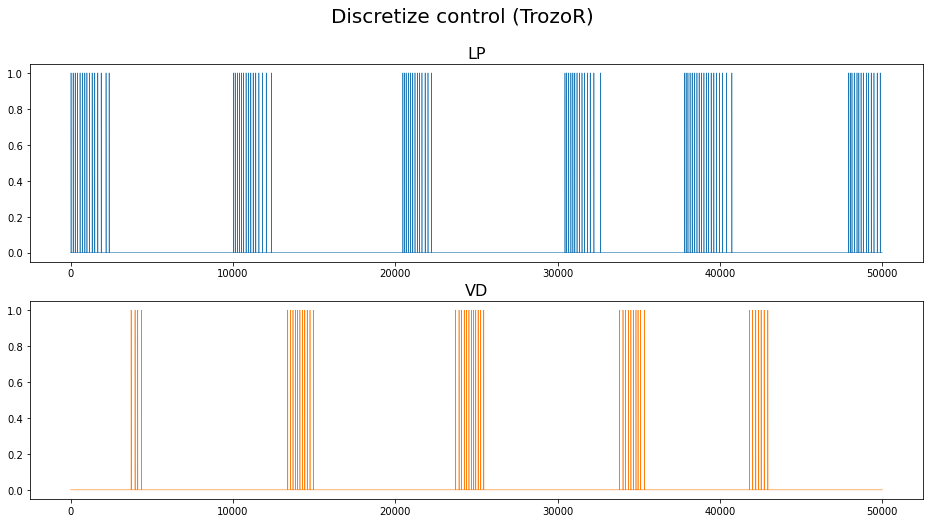

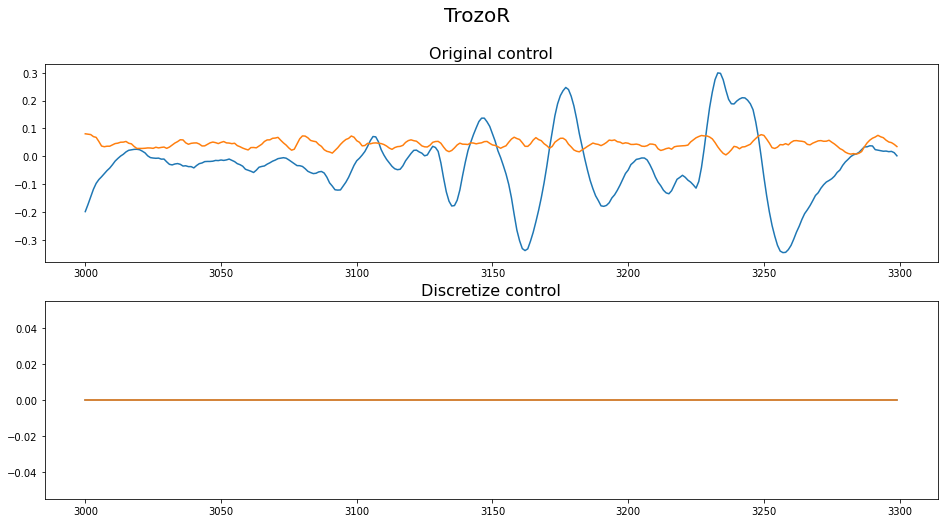

In [10]:
def discretize(trozo, clp_spikes, cvd_spikes):
    """
    
    """

    trozo['LP_events'] = 0
    trozo.loc[clp_spikes, 'LP_events'] = 1
    trozo['VD_events'] = 0
    trozo.loc[cvd_spikes, 'VD_events'] = 1
    return trozo

def show_discretize(trozo, name, n, sta, end):
    """
    
    """
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    plt.suptitle('Discretize control ({0})'.format(name), fontsize=20)
    ax1.plot(trozo.LP_events.iloc[:n],lw=0.6)
    ax1.set_title("LP", fontsize=16)
    ax2.plot(trozo.VD_events.iloc[:n],'tab:orange',lw=0.6)
    ax2.set_title("VD", fontsize=16)
    
    fig, (ax3, ax4) = plt.subplots(2,1)
    fig.set_size_inches(16, 8)
    plt.suptitle('{0}'.format(name), fontsize=20)
    ax3.plot(trozo['LP'].iloc[sta:end], label='LP')
    ax3.plot(trozo['VD'].iloc[sta:end], label='VD')
    ax3.set_title("Original control", fontsize=16)

    ax4.plot(trozo['LP_events'].iloc[sta:end], label='LP events')
    ax4.plot(trozo['VD_events'].iloc[sta:end], 'tab:orange', label='VD events')
    ax4.set_title("Discretize control", fontsize=16)
    
    return trozo


trozoC = discretize(trozoC, clp_spikes_C, cvd_spikes_C)
show_discretize(trozoC, 'TrozoC', 50000, 3000, 3300)

trozoG = discretize(trozoG, clp_spikes_G, cvd_spikes_G)
show_discretize(trozoG, 'TrozoG', 50000, 3000, 3300)

trozoR = discretize(trozoR, clp_spikes_R, cvd_spikes_R)
show_discretize(trozoR, 'TrozoR', 50000, 3000, 3300)

### 2.4. Tamaño de ventana

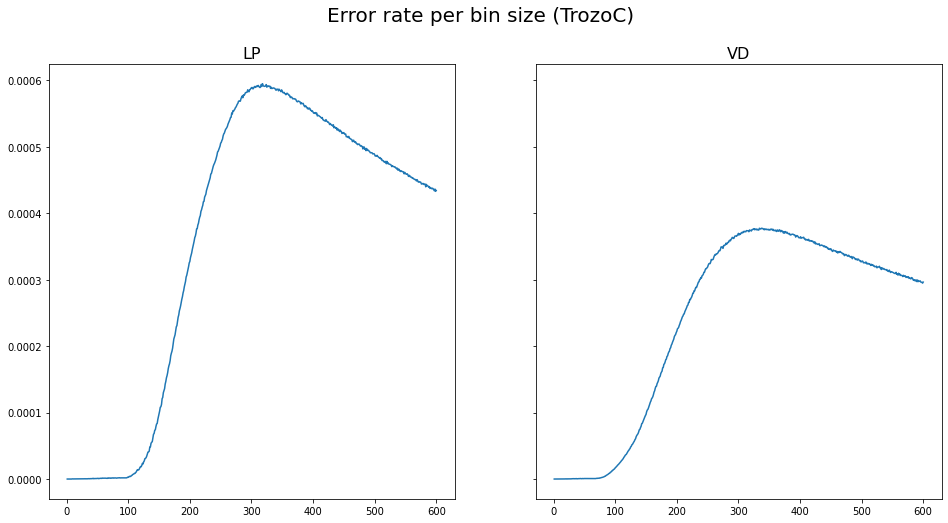

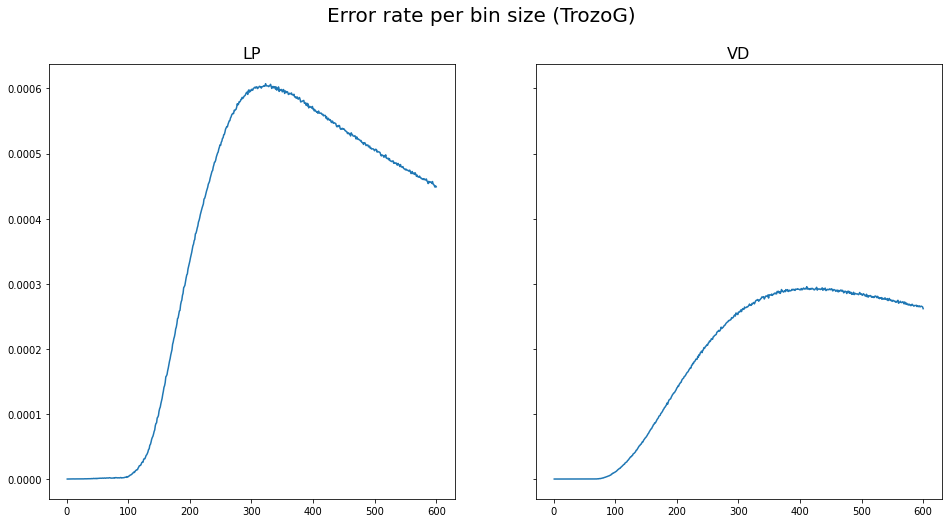

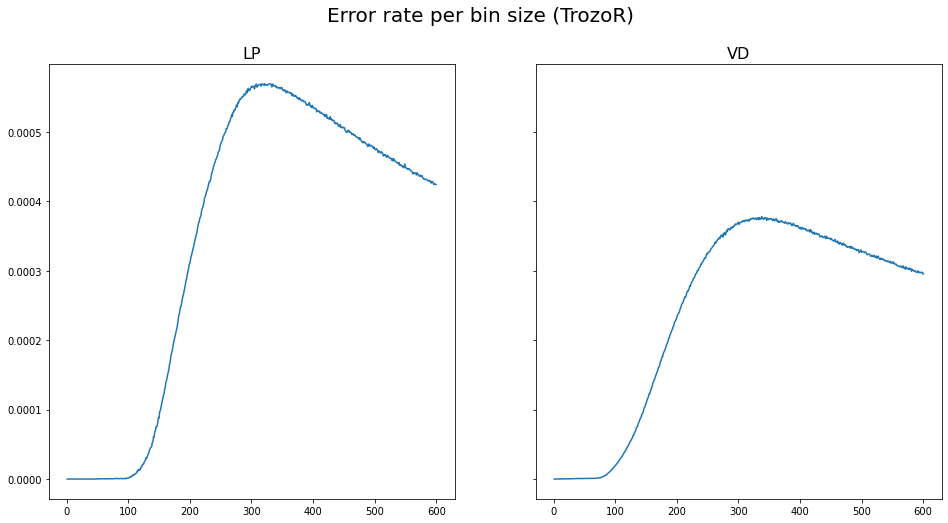

In [11]:
def get_errors_rate(series, bin_sizes):
    """

    """

    errors_rate = []
    for bin_size in bin_sizes:
        bins_spikes = view_as_windows(series, window_shape=bin_size, step=bin_size).sum(axis=1)
        errors_rate.append((bins_spikes>1).sum()/len(series))
    return np.array(errors_rate)

def get_errors_rate_per_neuron(trozo, name, bin_sizes):
    """
    
    """

    clp_errors = get_errors_rate(np.array(trozo.LP_events),bin_sizes)
    cvd_errors = get_errors_rate(np.array(trozo.VD_events),bin_sizes)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(16, 8)
    plt.suptitle('Error rate per bin size ({0})'.format(name), fontsize=20)
    ax1.plot(bin_sizes, clp_errors)
    ax1.set_title("LP", fontsize=16)
    ax2.plot(bin_sizes, cvd_errors)
    ax2.set_title("VD", fontsize=16)
    
    return clp_errors, cvd_errors

clp_errors_C, cvd_errors_C = get_errors_rate_per_neuron(trozoC, 'TrozoC', range(1,601))
clp_errors_G, cvd_errors_G = get_errors_rate_per_neuron(trozoG, 'TrozoG', range(1,601))
clp_errors_R, cvd_errors_R = get_errors_rate_per_neuron(trozoR, 'TrozoR', range(1,601))

## 3. Cálculo de la entropía y la información mutua

In [12]:
def to_words(series, nbits, nsteps):
    """

    """
    
    if nbits == 1:
        return np.array(list(map(str,series)))
    else:
        series_bin = view_as_windows(np.array(series), window_shape=nbits, step=nsteps)
        return np.array([''.join(map(str,bins)) for bins in series_bin])

def prob(x): # x : np of str (words)
    """

    """
    
    keys, counts = np.unique(x, return_counts=True)
    return dict(zip(keys,counts/len(x)))

def joint_prob(x, y):  # x,y : np of str (words)
    """

    """
    
    xy = list(map('|'.join,zip(x, y)))
    keys, counts = np.unique(xy, return_counts=True)
    return dict(zip(keys,counts/len(x)))

def entropy(x): # x : dict of probabilities
    """

    """
    
    return - np.sum([w * np.log2(w) for w in x.values()])
    
def MI(x, y): # x,y : np of str (words)
    """

    """
    
    px, py, pxy = prob(x),prob(y),joint_prob(x,y)
    ex, ey = entropy(px), entropy(py)
    mi=0
    for k in pxy:
        kx, ky = k.split('|')
        mi += pxy[k] * np.log2(pxy[k]/(px[kx] * py[ky]))
    return mi, ex, ey

In [13]:
def show_probabilities(nbits, trozo, name):
    """

    """
    
    print("________________ {0} ________________".format(name))
    clp_words = to_words(trozo.LP_events, nbits, nbits)
    cvd_words = to_words(trozo.VD_events, nbits, nbits)
    prob_clp,prob_cvd = prob(clp_words),prob(cvd_words)
    joint_prob_lpvd = joint_prob(clp_words,cvd_words)
    mi, e_clp, e_cvd = MI(clp_words,cvd_words)
    print("Probabilidades {0} LP con {1} bit: \n{2}".format(name,nbits, json.dumps(prob_clp,sort_keys=True, indent=2)))
    print("\nProbabilidades {0} VD con {1} bit: \n{2}".format(name,nbits, json.dumps(prob_cvd,sort_keys=True, indent=2)))
    print("\nProbabilidades Conjuntas {0} LP y VD con {1} bit: \n{2}".format(name,nbits, json.dumps(joint_prob_lpvd,sort_keys=True, indent=2)))
    print("\nEntropía {0} LP con {1} bit: {2}".format(name,nbits, e_clp))
    print("\nEntropía {0} VD con {1} bit: {2}".format(name,nbits, e_cvd))
    print("\nInformación Mutua {0} LP y VD con {1} bit: {2}".format(name,nbits, mi))

Ejemplo de la información obtenida para las señales LP y VD de Control utilizando un tamaño de ventana igual a 1, y un tamaño de palabra igual a 2.

In [29]:
show_probabilities(2,trozoC, 'TrozoC')

#[show_probabilities(i, trozoC, 'TrozoC') for i in [1,2,8]]
#[show_probabilities(i, trozoG, 'TrozoG') for i in [1,2,8]]
#[show_probabilities(i, trozoR, 'TrozoR') for i in [1,2,8]]

________________ TrozoC ________________
Probabilidades TrozoC LP con 2 bit: 
{
  "00": 0.9968529351007925,
  "01": 0.0015712651843790464,
  "10": 0.0015757997148284184
}

Probabilidades TrozoC VD con 2 bit: 
{
  "00": 0.9977493613869617,
  "01": 0.0011250673881608448,
  "10": 0.0011255712248774417
}

Probabilidades Conjuntas TrozoC LP y VD con 2 bit: 
{
  "00|00": 0.9946024980224409,
  "00|01": 0.001124865853474206,
  "00|10": 0.0011255712248774417,
  "01|00": 0.001571164417035727,
  "01|01": 1.0076734331937706e-07,
  "10|00": 0.001575698947485099,
  "10|01": 1.0076734331937706e-07
}

Entropía TrozoC LP con 2 bit: 0.03383786612648184

Entropía TrozoC VD con 2 bit: 0.02528934614122324

Información Mutua TrozoC LP y VD con 2 bit: 9.120518151655362e-06


In [14]:
def compute_signal_by_bins(bin_sizes, trozo):
    """
    
    """
    
    lp_bins, vd_bins = {}, {}
    for bin_size in bin_sizes:
        lp_bins[bin_size] = view_as_windows(np.array(trozo.LP_events), window_shape=bin_size, step=bin_size).sum(axis=1)
        vd_bins[bin_size] = view_as_windows(np.array(trozo.VD_events), window_shape=bin_size, step=bin_size).sum(axis=1)
    
    return lp_bins, vd_bins

def compute_information(bits_size, bin_size, lp_bins, vd_bins, fix):
    """
    
    """
    information = {}
    for nbits in bits_size:
        mi_l, elp_l, evd_l = [], [], []
        for nbin in bin_size:
            if fix == True:
                lp_words = to_words(lp_bins[nbin], nbits, nbits)
                vd_words = to_words(vd_bins[nbin], nbits, nbits)
            else:
                lp_words = to_words(lp_bins[nbin], nbits, 1)
                vd_words = to_words(vd_bins[nbin], nbits, 1)
            m_i, e_lp, e_vd = MI(lp_words,vd_words)
            mi_l.append(m_i)
            elp_l.append(e_lp)
            evd_l.append(e_vd)
        information[nbits] = {'mi': np.array(mi_l),'elp': np.array(elp_l),'evd': np.array(evd_l), 'ti_lp_vd':np.array(mi_l)/np.array(elp_l), 'ti_vd_lp':np.array(mi_l)/np.array(evd_l)}
    return information

In [16]:
bin_size = range(1,601)
lp_bins_C, vd_bins_C = compute_signal_by_bins(bin_size, trozoC)
lp_bins_G, vd_bins_G = compute_signal_by_bins(bin_size, trozoG)
lp_bins_R, vd_bins_R = compute_signal_by_bins(bin_size, trozoR)

### Palabras fijas

In [ ]:
bits_size = range(1,9)
information_C = compute_information(bits_size, bin_size, lp_bins_C, vd_bins_C, True)
information_G = compute_information(bits_size, bin_size, lp_bins_G, vd_bins_G, True)
information_R = compute_information(bits_size, bin_size, lp_bins_R, vd_bins_R, True)

In [ ]:
def plot_mutual_information(information_C, information_G, information_R, bits_size, bin_size):
    """
    
    """

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(16, 8)
    plt.suptitle(f'Mutual Information', fontsize=20)
    

    for nbits in bits_size:
        ax1.plot(bin_size, information_C[nbits]['mi'], label = f"{nbits} bits")
    ax1.set_title("TrozoC", fontsize=16)
    ax1.set_xlabel("Bin size")
    ax1.legend()

    for nbits in bits_size:
        ax2.plot(bin_size, information_G[nbits]['mi'], label = f"{nbits} bits")
    ax2.set_title("TrozoG", fontsize=16)
    ax2.set_xlabel("Bin size")
    ax2.legend()

    for nbits in bits_size:
        ax2.plot(bin_size, information_R[nbits]['mi'], label = f"{nbits} bits")
    ax3.set_title("TrozoR", fontsize=16)
    ax3.set_xlabel("Bin size")
    ax3.legend()
    
    plt.show()
    
plot_mutual_information(informationC, informationG, informationR, bits_size, bin_size)

In [ ]:
def plot_entropia(informationC,,informationG,informationR bits_size, bin_size, name):
    fig, axes = plt.subplots(len(bits_size), 3, figsize=(20, 30))
    plt.suptitle(f'Entropy', fontsize=20)
    for nbits,row in enumerate(axes):
        row[0].plot(bin_size,informationC[nbits+1]['elp'],label='LP')
        row[0].plot(bin_size,informationC[nbits+1]['evd'],label='VD')
        row[0].set_title(f"TrozoC ({nbits+1} nbits)")
        row[0].legend()

        row[1].plot(bin_size,informationG[nbits+1]['elp'],label='LP')
        row[1].plot(bin_size,informationG[nbits+1]['evd'],label='VD')
        row[1].set_title(f"TrozoG ({nbits+1} nbits)")
        row[1].legend()

        row[2].plot(bin_size,informationR[nbits+1]['elp'],label='LP')
        row[2].plot(bin_size,informationR[nbits+1]['evd'],label='VD')
        row[2].set_title(f"TrozoR ({nbits+1} nbits)")
        row[2].legend()

    plt.show()
    
plot_entropia(informationC, informationG, informationR, bits_size, bin_size)

In [ ]:
def plot_transfer_info(informationC,,informationG,informationR bits_size, bin_size, name):
    fig, axes = plt.subplots(len(bits_size), 3, figsize=(20, 30))
    plt.suptitle(f'Information transmission', fontsize=20)
    for nbits,row in enumerate(axes):
        row[0].plot(bin_size,informationC[nbits+1]['ti_lp_vd'],label='LP --> VD')
        row[0].plot(bin_size,informationC[nbits+1]['ti_vd_lp'],label='VD --> LP')
        row[0].set_title(f"TrozoC ({nbits+1} nbits)")
        row[0].legend()

        row[1].plot(bin_size,informationG[nbits+1]['ti_lp_vd'],label='LP --> VD')
        row[1].plot(bin_size,informationG[nbits+1]['ti_vd_lp'],label='VD --> LP')
        row[1].set_title(f"TrozoG ({nbits+1} nbits)")
        row[1].legend()

        row[2].plot(bin_size,informationR[nbits+1]['ti_lp_vd'],label='LP --> VD')
        row[2].plot(bin_size,informationR[nbits+1]['ti_vd_lp'],label='VD --> LP')
        row[2].set_title(f"TrozoR ({nbits+1} nbits)")
        row[2].legend()

    plt.show()
    
plot_transfer_info(informationC, informationG, informationR, bits_size, bin_size)

### Palabras solapadas

In [ ]:
bits_size = range(1,9)
information_C = compute_information(bits_size, bin_size, lp_bins_C, vd_bins_C, False)
information_G = compute_information(bits_size, bin_size, lp_bins_G, vd_bins_G, False)
information_R = compute_information(bits_size, bin_size, lp_bins_R, vd_bins_R, False)

In [ ]:
plot_mutual_information(informationC, informationG, informationR, bits_size, bin_size)

In [ ]:
plot_entropia(informationC, informationG, informationR, bits_size, bin_size)

In [ ]:
plot_transfer_info(informationC, informationG, informationR, bits_size, bin_size)

# Cambio de codificación: Bursts

En lugar de utilizar los spikes como eventos a analizar, en esta nueva codificación vamos a utilizar bursts, que son agrupaciones de spikes cercanos en el tiempo. De esta manera, los eventos de interés serán sucesiones de spikes.


In [ ]:
def get_bursts(trozo,clp_spikes):
    pass

### Palabras 1 bit

# ESTOY LIMPIANDO POR AQUI

In [78]:
def compute_mi_1(lp_bins, vd_bins, bin_sizes):
    """

    """
    nbits = 1
    mi, elp, evd = [], [], []
    for bin_size in bin_sizes:
        lp_words = to_words(lp_bins[bin_size], nbits, nbits)
        vd_words = to_words(vd_bins[bin_size], nbits, nbits)
        m_i, e_lp, e_vd = MI(lp_words,vd_words)
        mi.append(m_i)
        elp.append(e_lp)
        evd.append(e_vd)
    mi = np.array(mi)
    elp = np.array(elp)
    evd = np.array(evd)
    ti_lp_vd = mi/elp
    ti_vd_lp = mi/evd
    return mi, elp, evd, ti_lp_vd, ti_vd_lp

# TROZO C
mi, elp, evd, ti_lp_vd, ti_vd_lp = compute_mi_1(lp_bins_C, vd_bins_C, range(1,601))

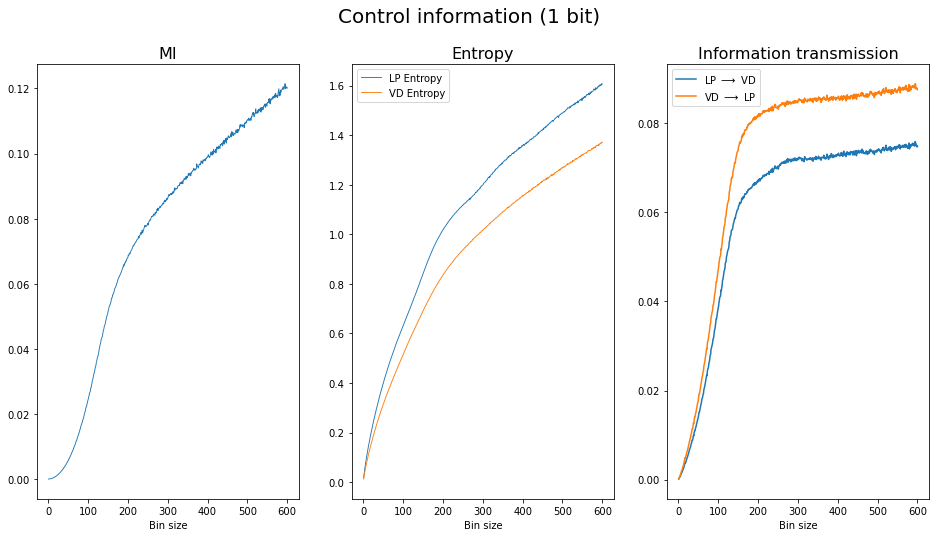

In [79]:
def plot_mi_en_tr(mi, elp, evd, ti_lp_vd, ti_vd_lp, bin_sizes):
    """
    
    """

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(16, 8)
    plt.suptitle(f'Control information (1 bit)', fontsize=20)

    ax1.plot(bin_sizes, mi, lw=0.9)
    ax1.set_title("MI", fontsize=16)
    ax1.set_xlabel("Bin size")

    ax2.plot(bin_sizes, elp, lw=0.9, label='LP Entropy')
    ax2.plot(bin_sizes, evd,'tab:orange', label='VD Entropy', lw=0.9)
    ax2.set_title("Entropy", fontsize=16)
    ax2.set_xlabel("Bin size")
    ax2.legend()

    ax3.plot(bin_sizes, ti_lp_vd, label = r'LP $\longrightarrow$ VD')
    ax3.plot(bin_sizes, ti_vd_lp, label = r'VD $\longrightarrow$ LP')
    ax3.set_title('Information transmission', fontsize=16)
    ax3.set_xlabel("Bin size")
    ax3.legend()

plot_mi_en_tr(mi, elp, evd, ti_lp_vd, ti_vd_lp, range(1,601))

### Para cada tamaño de palabra

In [81]:
#TROZO C

bin_sizes = range(1,601)
nbits_size = range(1,9)
mi, elp, evd, ti_lp_vd, ti_vd_lp  = {},{},{},{},{}
for nbits in nbits_size:
    mi_l, elp_l, evd_l = [], [], []
    for bin_size in bin_sizes:
        lp_words = to_words(lp_bins_C[bin_size], nbits, nbits)
        vd_words = to_words(vd_bins_C[bin_size], nbits, nbits)
        m_i, e_lp, e_vd = MI(lp_words,vd_words)
        mi_l.append(m_i)
        elp_l.append(e_lp)
        evd_l.append(e_vd)
    mi[nbits] = np.array(mi_l)
    elp[nbits] = np.array(elp_l)
    evd[nbits] = np.array(evd_l)
    ti_lp_vd[nbits] = np.array(mi_l)/np.array(elp_l)
    ti_vd_lp[nbits] = np.array(mi_l)/np.array(evd_l)

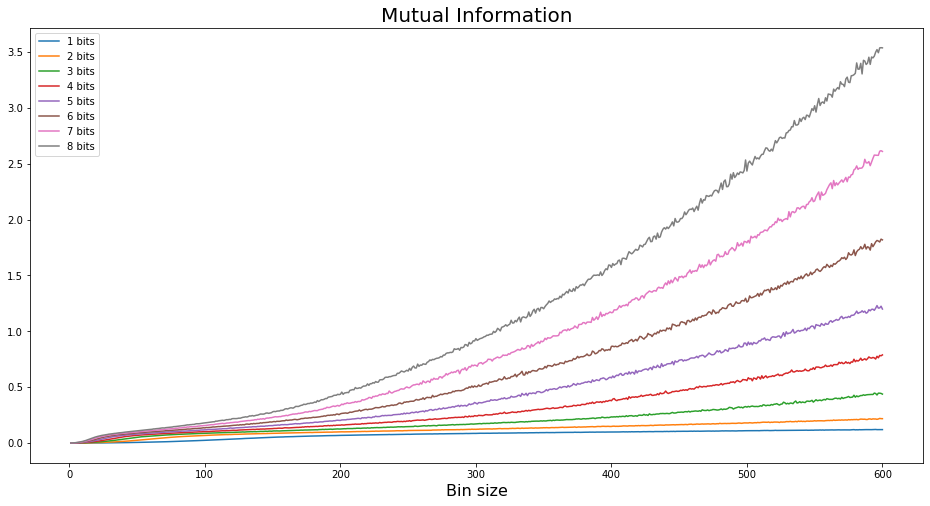

In [82]:
plt.figure(figsize=(16, 8))
plt.title("Mutual Information", fontsize=20)
plt.xlabel("Bin size", fontsize=16)
for nbits in nbits_size:
    plt.plot(bin_sizes, mi[nbits], label = f"{nbits} bits")
plt.legend()
plt.show()

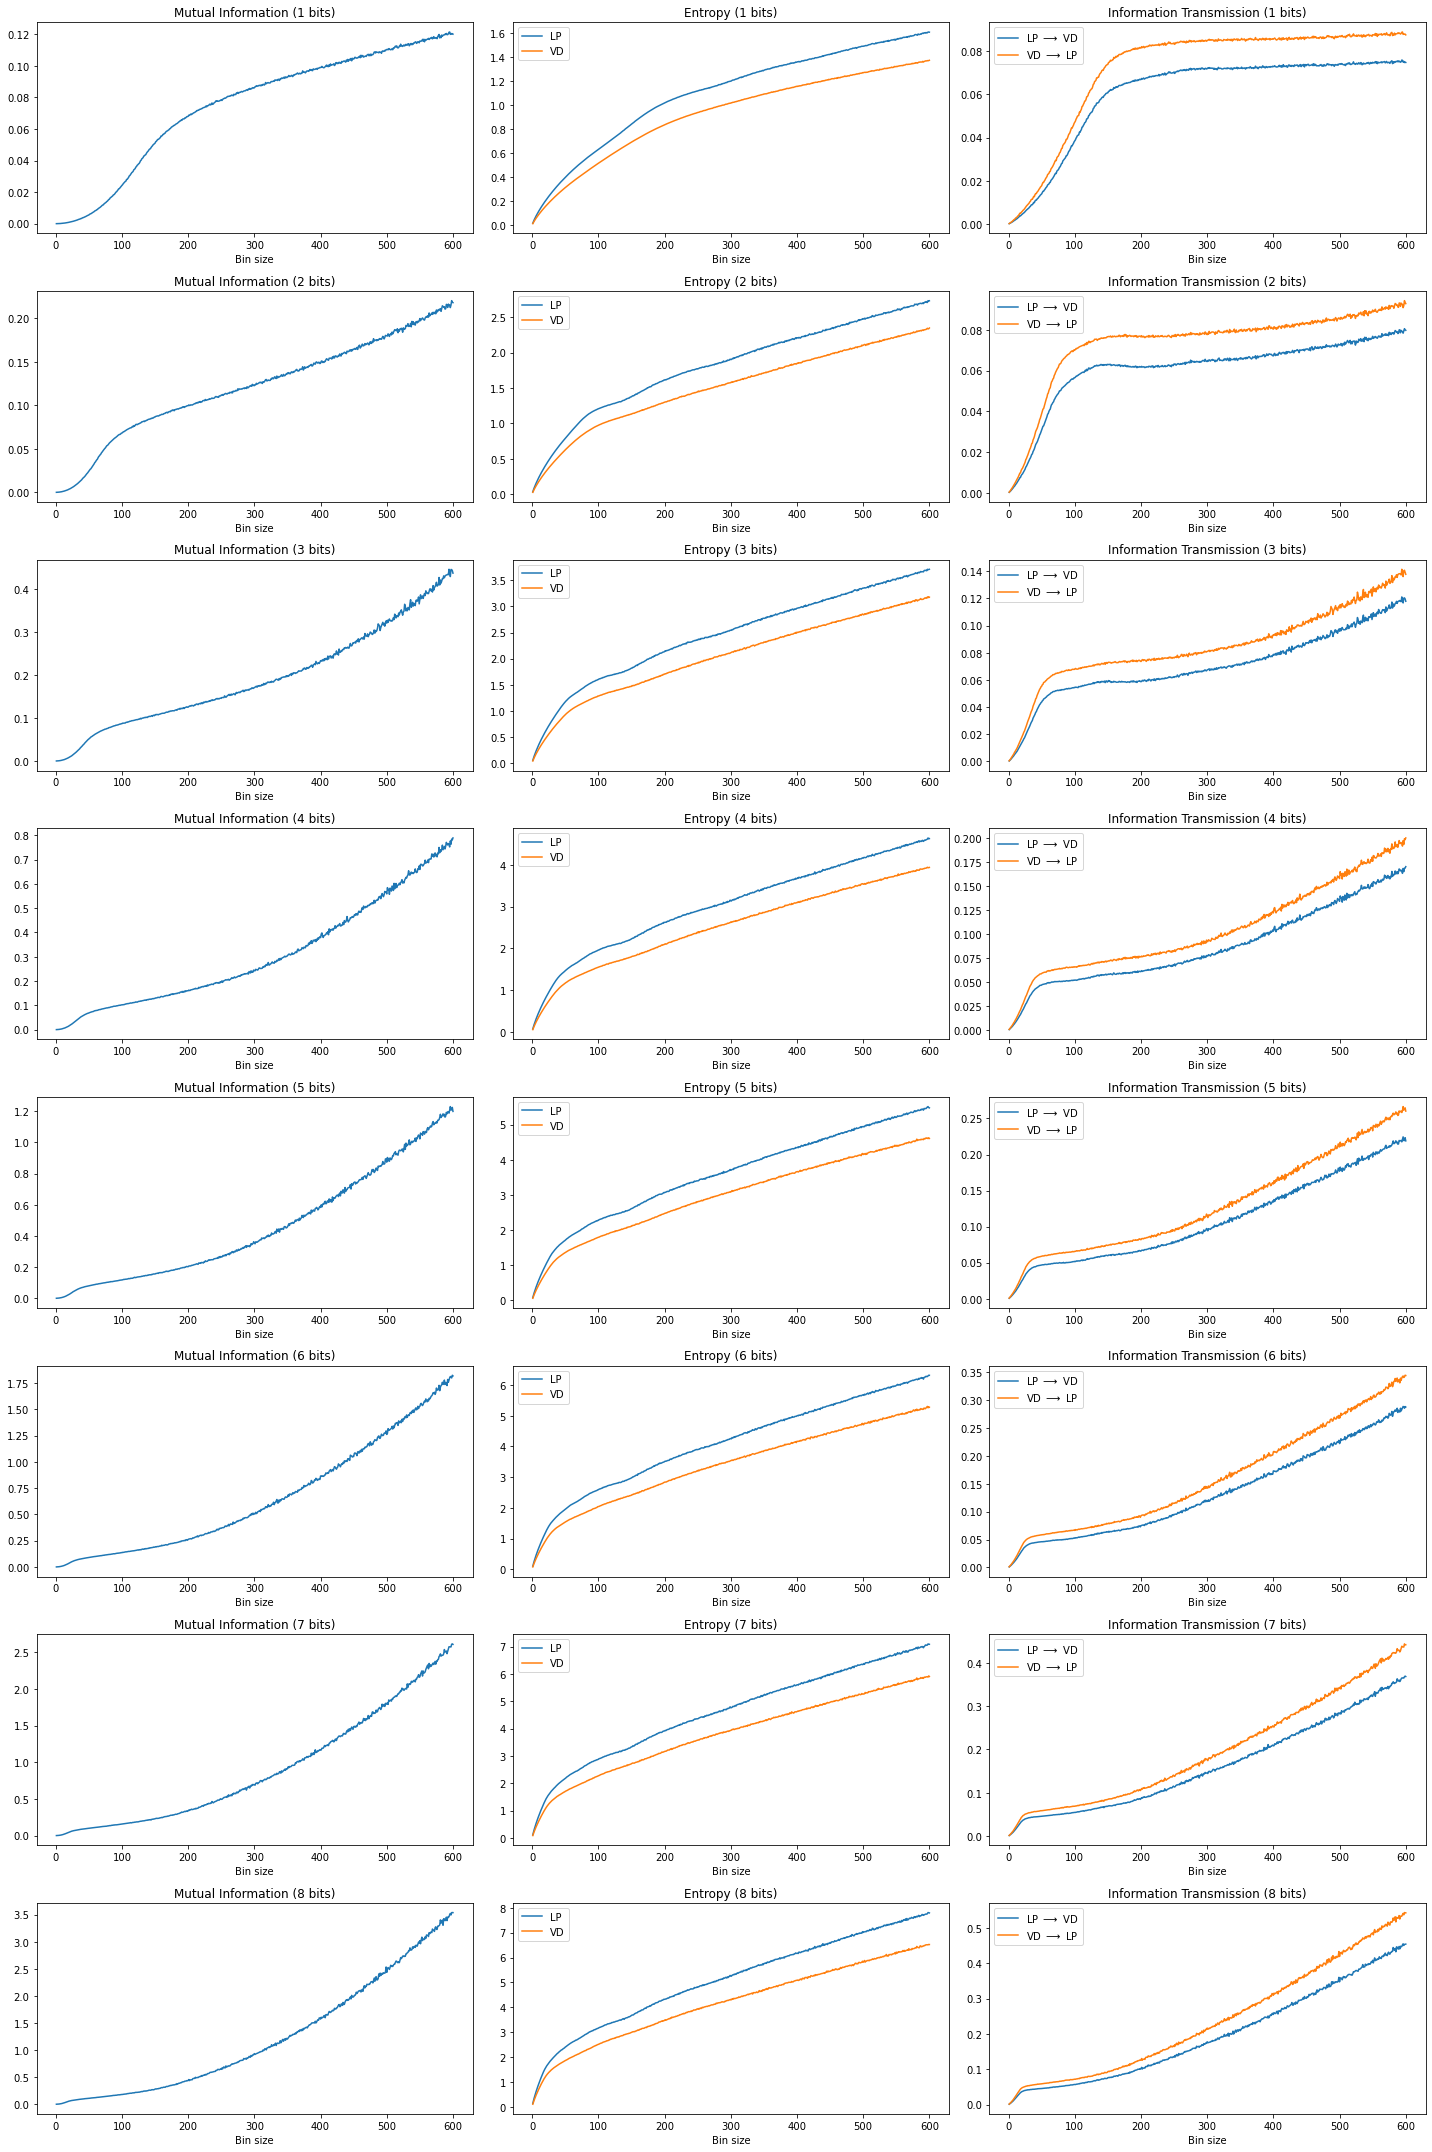

In [85]:
#Trozo C

fig, axes = plt.subplots(len(nbits_size), 3, figsize=(20, 30))

for nbits,row in enumerate(axes):
    x = np.random.normal(0, 1, 100).cumsum()
    y = np.random.normal(0, 0.5, 100).cumsum()
    row[0].plot(bin_sizes,mi[nbits+1])
    row[0].set_title(f"Mutual Information ({nbits+1} bits)")
    row[0].set_xlabel("Bin size")

    row[1].plot(bin_sizes,elp[nbits+1],label='LP')
    row[1].plot(bin_sizes,evd[nbits+1],label='VD')
    row[1].set_title(f"Entropy ({nbits+1} bits)")
    row[1].set_xlabel("Bin size")
    row[1].legend()
    
    row[2].plot(bin_sizes, ti_lp_vd[nbits+1], label = r'LP $\longrightarrow$ VD')
    row[2].plot(bin_sizes, ti_vd_lp[nbits+1], label = r'VD $\longrightarrow$ LP')
    row[2].set_title(f'Information Transmission ({nbits+1} bits)')
    row[2].set_xlabel("Bin size")
    row[2].legend()
    
fig.tight_layout()
    
plt.show()

### REVISAR ESTO --- Codificación palabras con desplazamiento solapantes

In [ ]:
bin_sizes = range(1,81)
nbits_size = range(1,9)
mi_s, elp_s, evd_s, ti_lp_vd_s, ti_vd_lp_s  = {},{},{},{},{}
for nbits in nbits_size:
    mi_l, elp_l, evd_l = [], [], []
    for bin_size in bin_sizes:
        lp_words = to_words(lp_bins[bin_size], nbits, 1)
        vd_words = to_words(vd_bins[bin_size], nbits, 1)
        m_i, e_lp, e_vd = MI(lp_words,vd_words)
        mi_l.append(m_i)
        elp_l.append(e_lp)
        evd_l.append(e_vd)
    mi_s[nbits] = np.array(mi_l)
    elp_s[nbits] = np.array(elp_l)
    evd_s[nbits] = np.array(evd_l)
    ti_lp_vd_s[nbits] = np.array(mi_l)/np.array(elp_l)
    ti_vd_lp_s[nbits] = np.array(mi_l)/np.array(evd_l)

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("MI")
plt.xlabel("Tamaño ventana")
for nbits in nbits_size:
    plt.plot(bin_sizes,mi_s[nbits], label = f"{nbits} bits")
plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(len(nbits_size), 3, figsize=(20, 30))

for nbits,row in enumerate(axes):
    x = np.random.normal(0, 1, 100).cumsum()
    y = np.random.normal(0, 0.5, 100).cumsum()
    row[0].plot(bin_sizes,mi_s[nbits+1])
    row[0].set_title(f"Mutual Information ({nbits+1} bits)")

    row[1].plot(bin_sizes,elp_s[nbits+1],label='LP')
    row[1].plot(bin_sizes,evd_s[nbits+1],label='VD')
    row[1].set_title(f"Entropy ({nbits+1} bits)")
    row[1].legend()
    
    row[2].plot(bin_sizes,ti_lp_vd_s[nbits+1],label = 'LP --> VD')
    row[2].plot(bin_sizes,ti_vd_lp_s[nbits+1],label = 'VD --> LP')
    row[2].set_title(f'Information transmission ({nbits+1} bits)')
    row[2].legend()
    
plt.show()